<h1 align="center">Sentiment Analysis of Music Lyrics Using NLP Techniques</h1>

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 2. Load Datasets

In [2]:
songs_df = pd.read_csv('/kaggle/input/musicoset-dataset/musicoset_metadata/songs.csv', sep='\t')
lyrics_df = pd.read_csv('/kaggle/input/musicoset-dataset/musicoset_songfeatures/lyrics.csv', sep='\t')
acoustic_df = pd.read_csv('/kaggle/input/musicoset-dataset/musicoset_songfeatures/acoustic_features.csv', sep='\t')

## 3. Dataset Preview

In [3]:
songs_df.head()

,song_id,song_name,billboard,artists,popularity,explicit,song_type
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},86,True,Solo
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,"('Without Me', 'Halsey')",{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},87,True,Solo
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,"('Sicko Mode', 'Travis Scott')",{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},85,True,Solo
3,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,('Sunflower (Spider-Man: Into The Spider-Verse...,"{'246dkjvS1zLTtiykXe5h60': 'Post Malone', '1zN...",92,False,Collaboration
4,1rqqCSm0Qe4I9rUvWncaom,High Hopes,"('High Hopes', 'Panic! At The Disco')",{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},86,False,Solo


In [4]:
lyrics_df.head()

,song_id,lyrics
0,3e9HZxeyfWwjeyPAMmWSSQ,['[Verse 1]\nThought I\'d end up with Sean\nBu...
1,5p7ujcrUXASCNwRaWNHR1C,"[""[Verse 1]\nFound you when your heart was bro..."
2,2xLMifQCjDGFmkHkpNLD9h,"['[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun..."
3,3KkXRkHbMCARz0aVfEt68P,NaN
4,1rqqCSm0Qe4I9rUvWncaom,"[""[Intro]\nHigh, high hopes\n\n[Chorus]\nHad t..."


In [5]:
acoustic_df.head()

,song_id,duration_ms,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,3e9HZxeyfWwjeyPAMmWSSQ,207320,1,1,4,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966
1,5p7ujcrUXASCNwRaWNHR1C,201661,6,1,4,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041
2,2xLMifQCjDGFmkHkpNLD9h,312820,8,1,4,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008
3,3KkXRkHbMCARz0aVfEt68P,158040,2,1,4,0.55600,0.760,0.479,0.000000,0.0703,-5.574,0.0466,0.913,89.911
4,1rqqCSm0Qe4I9rUvWncaom,190947,5,1,4,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014


In [6]:
print(f"Shape of songs dataset: {songs_df.shape}")
print(f"Shape of lyrics dataset: {lyrics_df.shape}")
print(f"Shape of acoustic dataset: {acoustic_df.shape}")

Shape of songs dataset: (20405, 7)
Shape of lyrics dataset: (20404, 2)
Shape of acoustic dataset: (20405, 14)


In [7]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20405 entries, 0 to 20404
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     20405 non-null  object
 1   song_name   20405 non-null  object
 2   billboard   20405 non-null  object
 3   artists     20405 non-null  object
 4   popularity  20405 non-null  int64 
 5   explicit    20405 non-null  bool  
 6   song_type   20405 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 976.5+ KB


In [8]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20404 entries, 0 to 20403
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   song_id  20404 non-null  object
 1   lyrics   19663 non-null  object
dtypes: object(2)
memory usage: 318.9+ KB


In [9]:
acoustic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20405 entries, 0 to 20404
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           20405 non-null  object 
 1   duration_ms       20405 non-null  int64  
 2   key               20405 non-null  int64  
 3   mode              20405 non-null  int64  
 4   time_signature    20405 non-null  int64  
 5   acousticness      20405 non-null  float64
 6   danceability      20405 non-null  float64
 7   energy            20405 non-null  float64
 8   instrumentalness  20405 non-null  float64
 9   liveness          20405 non-null  float64
 10  loudness          20405 non-null  float64
 11  speechiness       20405 non-null  float64
 12  valence           20405 non-null  float64
 13  tempo             20405 non-null  float64
dtypes: float64(9), int64(4), object(1)
memory usage: 2.2+ MB


In [10]:
# Check for duplicates
lyrics_df['lyrics'].duplicated().sum()

1377

## 4. Data Wrangling

### 4.1. Merge songs with lyrics and acoustic features

In [11]:
merged_df = pd.merge(songs_df, lyrics_df, on='song_id')
merged_df = pd.merge(merged_df, acoustic_df, on='song_id')

In [12]:
merged_df.shape

(20404, 21)

### 4.2. Format artist names

In [13]:
def clean_artist(artist):
    artists = list(eval(artist).values())
    if len(artists) == 1:
        return artists[0]
    return artists

In [14]:
list(eval(merged_df['artists'][0]).values())

['Ariana Grande']

In [15]:
merged_df['cleaned_artists'] = merged_df['artists'].apply(clean_artist)

merged_df.head()

,song_id,song_name,billboard,artists,popularity,explicit,song_type,lyrics,duration_ms,key,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,cleaned_artists
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},86,True,Solo,['[Verse 1]\nThought I\'d end up with Sean\nBu...,207320,1,...,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,Ariana Grande
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,"('Without Me', 'Halsey')",{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},87,True,Solo,"[""[Verse 1]\nFound you when your heart was bro...",201661,6,...,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,Halsey
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,"('Sicko Mode', 'Travis Scott')",{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},85,True,Solo,"['[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun...",312820,8,...,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,Travis Scott
3,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,('Sunflower (Spider-Man: Into The Spider-Verse...,"{'246dkjvS1zLTtiykXe5h60': 'Post Malone', '1zN...",92,False,Collaboration,NaN,158040,2,...,0.55600,0.760,0.479,0.000000,0.0703,-5.574,0.0466,0.913,89.911,"[Post Malone, Swae Lee]"
4,1rqqCSm0Qe4I9rUvWncaom,High Hopes,"('High Hopes', 'Panic! At The Disco')",{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},86,False,Solo,"[""[Intro]\nHigh, high hopes\n\n[Chorus]\nHad t...",190947,5,...,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,Panic! At The Disco


### 4.3. Drop all musics without lyrics

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20404 entries, 0 to 20403
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           20404 non-null  object 
 1   song_name         20404 non-null  object 
 2   billboard         20404 non-null  object 
 3   artists           20404 non-null  object 
 4   popularity        20404 non-null  int64  
 5   explicit          20404 non-null  bool   
 6   song_type         20404 non-null  object 
 7   lyrics            19663 non-null  object 
 8   duration_ms       20404 non-null  int64  
 9   key               20404 non-null  int64  
 10  mode              20404 non-null  int64  
 11  time_signature    20404 non-null  int64  
 12  acousticness      20404 non-null  float64
 13  danceability      20404 non-null  float64
 14  energy            20404 non-null  float64
 15  instrumentalness  20404 non-null  float64
 16  liveness          20404 non-null  float6

In [17]:
merged_df = merged_df.dropna()

In [18]:
merged_df.shape

(19663, 22)

### 4.4. Drop all musics with duplicated lyrics

In [19]:
merged_df[merged_df.duplicated(subset=['lyrics'])][['song_name', 'cleaned_artists', 'lyrics']].head()

,song_name,cleaned_artists,lyrics
935,Get Ugly,Jason Derulo,"[""The 1975, The Sound\n\n2 Chainz, Back On The..."
979,Gonna,Blake Shelton,"[""The 1975, The Sound\n\n2 Chainz, Back On The..."
988,Hallelujah,Lindsey Stirling,['[Instrumental]']
1071,Sangria,Blake Shelton,"[""The 1975, The Sound\n\n2 Chainz, Back On The..."
1213,Neon Light,Blake Shelton,"[""The 1975, The Sound\n\n2 Chainz, Back On The..."


In [20]:
# Find duplicated lyrics (both the original and duplicates)
duplicated_lyrics = merged_df[merged_df.duplicated(subset=['lyrics'], keep=False)]['lyrics']

# Since it is impossible to know which song actually has which lyrics, I decided to drop all rows with duplicated lyrics 
merged_df = merged_df[~merged_df['lyrics'].isin(duplicated_lyrics)]

# Reset dataframe index
merged_df = merged_df.reset_index(drop=True)

### 4.5. Preprocess song lyrics

In [21]:
# Kaggle required command
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ > null

In [22]:
merged_df['lyrics'].values[0]

'[\'[Verse 1]\\nThought I\\\'d end up with Sean\\nBut he wasn\\\'t a match\\nWrote some songs about Ricky\\nNow I listen and laugh\\nEven almost got married\\nAnd for Pete, I\\\'m so thankful\\nWish I could say, "Thank you" to Malcolm\\n\\\'Cause he was an angel\\n\\n[Pre-Chorus]\\nOne taught me love\\nOne taught me patience\\nAnd one taught me pain\\nNow, I\\\'m so amazing\\nSay I\\\'ve loved and I\\\'ve lost\\nBut that\\\'s not what I see\\nSo, look what I got\\nLook what you taught me\\nAnd for that, I say\\n\\n[Chorus]\\nThank you, next (Next)\\nThank you, next (Next)\\nThank you, next\\nI\\\'m so fuckin\\\' grateful for my ex\\nThank you, next (Next)\\nThank you, next (Next)\\nThank you, next (Next)\\nI\\\'m so fuckin\\\'—\\n\\n[Verse 2]\\nSpend more time with my friends\\nI ain\\\'t worried \\\'bout nothin\\\'\\nPlus, I met someone else\\nWe havin\\\' better discussions\\nI know they say I move on too fast\\nBut this one gon\\\' last\\n\\\'Cause her name is Ari\\nAnd I\\\'m so go

In [23]:
stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
# Extend stopwords to remove other common stopwords, musical terms and slangs 
stop_words.extend([
    'verse', 'chorus', 'i"ll', 'intro', 'outro', 'or', 'm', 'ma', 'ours', 'against', 'nor',
    'wasn', 'hasn', 'my', 'had', 'didn', 'isn', 'did', 'aren', 'those', 'than', 'man'
    "mustn't", "you've", 'to', 'she', 'having', "haven't", 'into', 't', 'll', 
    'himself', 'do', "that'll", 'so', 'of', 'on', 'very', 'for', 'out', 'were', 
    'should', 'they', 'ain', "should've", 'you', "didn't", 'yours', 'was', 'our',
     'can', 'myself', "shouldn't", 'have', 'up', 'mightn', "you'll", 'any', 
    'itself', 'hadn', 'him', 'doesn', 'weren', 'y', 'being', "don't", 'them', 
    'are','and', 'that', 'your', 'yourself', 'their', 'some', 'ourselves', 've', 
    'doing', 'been', 'shouldn', 'yourselves', "mightn't", 'most', 'because',
     'few', 'wouldn', "you'd", 'through', "you're", 'themselves', 'an', 'if',
     "wouldn't", 'its', 'other', "won't", "wasn't", "she's", 'we', 'shan',
     "weren't",'don',"hadn't", 'this', 'off', 'while', 'a', 'haven', 'her', 
    'theirs', 'all', "hasn't", "doesn't", 'about', 'then', 'by','such', 'but', 
    'until', 'each', 'there', "aren't", 'with', 'not', "shan't", 'hers', 'it', 
    'too', 'i', 'at', 'is', 'as', 'me', 'herself', 's', 'the', 'where', 'am', 
    'has', 'over', "couldn't", 'when', 'does', 'mustn','re', 'no', 'in', 'who', 
    'd', 'own', 'he', 'be', "isn't", 'his', 'these', 'same', 'whom', 'will', 
    'needn','couldn', 'from',  "it's", 'o', 'yeah','ya','na','wan','uh','gon',
    'ima','mm','uhhuh','bout','em','nigga','niggas','got','ta','lil','ol','hey',
    'oooh','ooh','oh','youre','dont','im','youve','ive','theres','ill','yaka',
    'lalalala','la','da','di','yuh', 'shawty','oohooh','shoorah','mmmmmm',
    'ook','bidibambambambam','shh','bro','ho','aint','cant','know','bambam',
    'shitll','tonka'
])

stop_words = set(stop_words)

In [25]:
# Pre-compile the regex pattern for removing escaped new line characters
newline_pattern = re.compile(r'\\n')

# Initialize lemmatizer 
lemmatizer = WordNetLemmatizer()

def preprocess_lyrics(lyrics):
    # Remove escaped new line character
    lyrics = newline_pattern.sub(' ', str(lyrics))
    
    # Tokenization
    tokens = word_tokenize(lyrics)
    
    # Process tokens: remove punctuation, convert to lowercase, remove stopwords, and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens if word.isalpha() and word.lower() not in stop_words
    ]
    
    return ' '.join(processed_tokens)

In [26]:
try:
    # Try to read the cleaned data from a CSV file
    merged_df = pd.read_csv("/kaggle/working/cleaned_data.csv")
except FileNotFoundError:
    # If the file is not found, process the data    
    merged_df['cleaned_lyrics'] = merged_df['lyrics'].apply(preprocess_lyrics)
    
    # Save the dataframe with the cleaned lyrics to a CSV file for future use 
    # This avoids the need to reprocess the lyrics in subsequent runs
    merged_df.to_csv("/kaggle/working/cleaned_data.csv", index=None)

In [27]:
merged_df['cleaned_lyrics']

0        thought end sean match wrote song ricky listen...
1        found heart broke filled cup overflowed took f...
2        part drake astro sun cold already dawg would p...
3        high high hope high high hope living shooting ...
4        want lot christmas one thing need care present...
                               ...                        
18800    ten little indian standing line one stood look...
18801    sure world constantly changing sure stand when...
18802    billy wood used clown kid like scared money ma...
18803    well better run run say somebody calling bette...
18804    round saurus look people salty thinking battle...
Name: cleaned_lyrics, Length: 18805, dtype: object

## 5. Data Visualization

In [28]:
sns.set_style('darkgrid')

### 5.1. Distribution of song popularity

In [29]:
mean_popularity = round(merged_df['popularity'].mean(), 2)
skewness_popularity = round(merged_df['popularity'].skew(), 2)

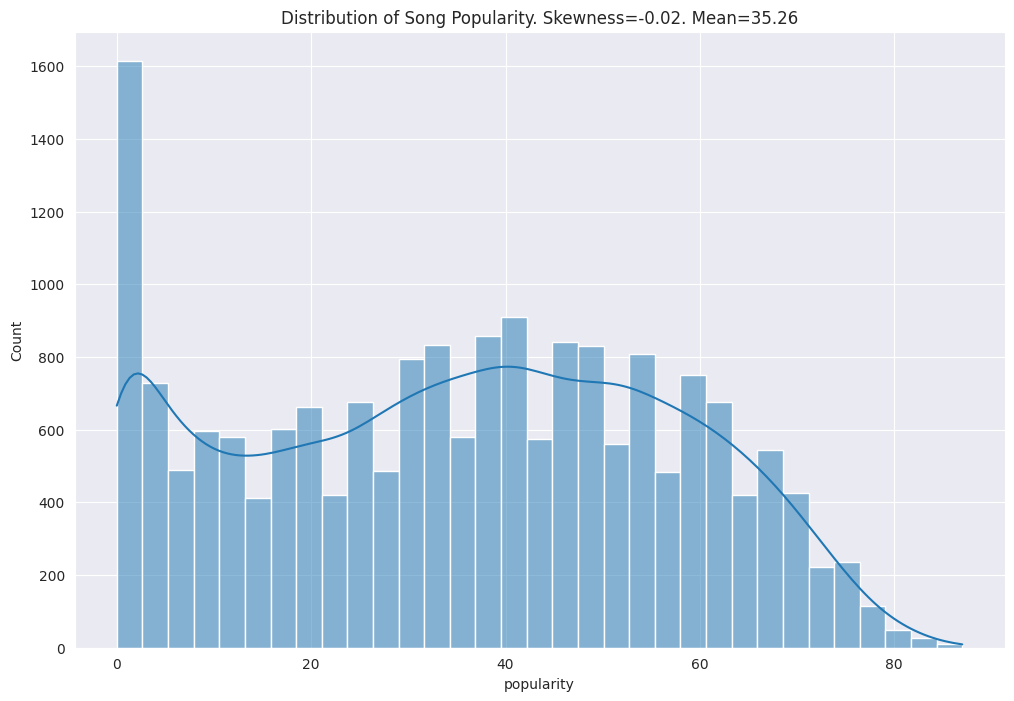

In [30]:
plt.figure(figsize=(12, 8))
sns.histplot(merged_df['popularity'], kde=True)
plt.title(f"Distribution of Song Popularity. Skewness={skewness_popularity}. Mean={mean_popularity}")
plt.show()

We can infer the following from the histogram:
- The tallest bar on the far left indicate a high count of songs with low popularity scores (close to 0). This show that while many songs are produced, only a small fraction achieve high popularity.
- The mean (average) popularity score is 35.26. This suggests that, on average, songs have a popularity score around 35.26.
- The skewness value of -0.02 indicates that the distribution of song popularity is nearly symmetrical, with a very slight tendency towards left skewness.

### 5.2. Artists with most solo songs

In [31]:
solo_songs = merged_df.query('song_type == "Solo"')

In [32]:
# Count occurrences of each artist
top_artists = solo_songs['cleaned_artists'].value_counts().head(10).sort_values(ascending=True)

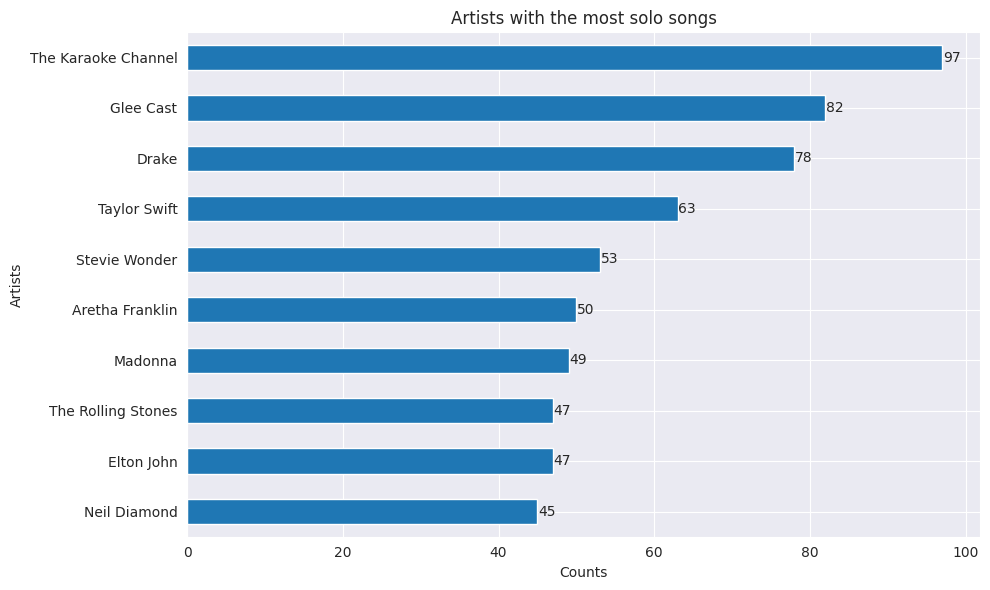

In [33]:
plt.figure(figsize=(10, 6))
bars = top_artists.plot(kind='barh')

# Adding counts at the top of each bar
for i, v in enumerate(top_artists):
    plt.text(v + 0.1, i, str(v), ha='left', va='center')  # Adjust the +0.1 for better positioning

plt.title('Artists with the most solo songs')
plt.ylabel('Artists')
plt.xlabel('Counts')
plt.tight_layout()
plt.show()

The Karaoke Channel have the highest number of solo songs (97), followed closely by Glee Cast with 82 and Drake with 78. Other notable artists include Taylor Swift, Stevie Wonder, and Aretha Franklin, each having 63, 53, and 50 solo songs respectively.

### 5.3. Songs with the Highest Popularity

In [34]:
top_10 = merged_df.sort_values(by='popularity', ascending=False).head(10)

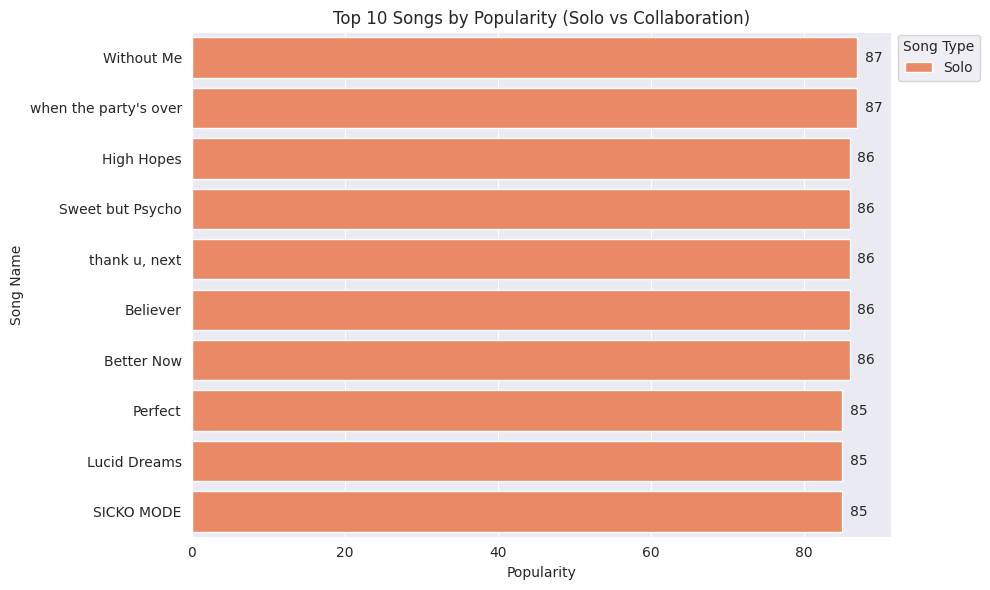

In [35]:
plt.figure(figsize=(10, 6))

palette = {'Solo': 'coral', 'Collaboration': 'orange'}
sns.barplot(x='popularity', y='song_name', data=top_10, hue='song_type', dodge=False, palette=palette)

# Adding counts at the top of each bar
for index, value in enumerate(top_10['popularity']):
    plt.text(value + 1, index, str(value), ha='left', va='center', fontsize=10)

# Shift legend outside of plot
plt.legend(title='Song Type', loc='center left', bbox_to_anchor=(1, 0.95))

plt.xlabel('Popularity')
plt.ylabel('Song Name')
plt.title('Top 10 Songs by Popularity (Solo vs Collaboration)')
plt.tight_layout()
plt.show()

“Without Me” by Halsey and “When the Party’s Over” by Billie Eilish share the top spot as the two most popular songs. Additionally, the fact that the top 10 songs are all solo tracks implies that solo songs have a higher likelihood of becoming hits compared to collaborative ones. 🎵🌟

### 5.4. WordCloud of song lyrics

In [36]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18805 entries, 0 to 18804
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           18805 non-null  object 
 1   song_name         18805 non-null  object 
 2   billboard         18805 non-null  object 
 3   artists           18805 non-null  object 
 4   popularity        18805 non-null  int64  
 5   explicit          18805 non-null  bool   
 6   song_type         18805 non-null  object 
 7   lyrics            18805 non-null  object 
 8   duration_ms       18805 non-null  int64  
 9   key               18805 non-null  int64  
 10  mode              18805 non-null  int64  
 11  time_signature    18805 non-null  int64  
 12  acousticness      18805 non-null  float64
 13  danceability      18805 non-null  float64
 14  energy            18805 non-null  float64
 15  instrumentalness  18805 non-null  float64
 16  liveness          18805 non-null  float6

In [37]:
all_text = ' '.join(merged_df['cleaned_lyrics'])

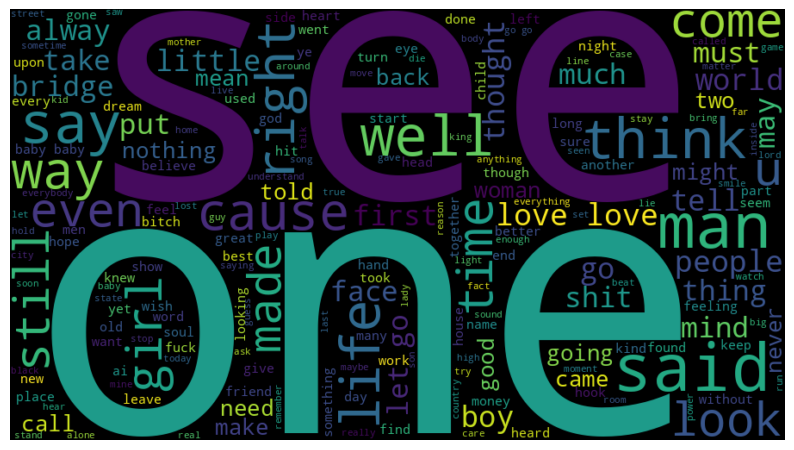

In [38]:
wordcloud = WordCloud(width=900, height=500, background_color='black', random_state=42).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 6. Sentiment Analysis

Before proceeding, here are some business questions I aim to answer 

- Artist Sentiment Trend: What is the overall sentiment of songs by a particular artist? Is there a trend towards more positive or negative sentiment over time?

- Song Sentiment vs. Popularity: Is there a correlation between the sentiment of song lyrics and their popularity? Do more positive songs tend to be more popular? 

- Explicit Content and Sentiment: How does the sentiment of explicit songs compare to non-explicit songs? Are explicit songs generally more negative or positive?

- Sentiment by Song Type: Does the sentiment differ significantly between solo performances and collaborations (duets, groups)?

- Comparing Sentiment Across Artists: How do different artists compare in terms of the sentiment of their song lyrics? Are some artists consistently more positive or negative?

- Extreme Values: Which songs have the most extreme sentiment scores (both positive and negative)? What might account for these?

### 6.1. Sentiment Analysis using Vader

There are four sentiment type values returned when we use vader sentiment analyzer:

- neg for negative sentiment
- neu for neutral sentiment
- pos for positive sentiment
- compound for an overall score that combines negative, positive, and neutral sentiments into a single score. 

In our case, the compound score is the most useful metric since we want a single unidimensional measure of sentiment for a given sentence. The threshold value I used is

- positive sentiment: compound score > 0
- negative sentiment: compound score < 0
- neutral sentiment: compound score = 0

In [39]:
analyzer = SentimentIntensityAnalyzer()

In [40]:
def analyze_sentiment(lyrics):
    scores = analyzer.polarity_scores(lyrics)
    compound_score = scores['compound']
    if compound_score > 0:
        sentiment = 'positive'
    elif compound_score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return compound_score, sentiment

In [41]:
view_cols = ['song_name', 'popularity', 'cleaned_artists', 'cleaned_lyrics', 'vader_compound_score', 'vader_sentiment']

merged_df[['vader_compound_score', 'vader_sentiment']] = merged_df['cleaned_lyrics'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [42]:
merged_df[view_cols].head()

,song_name,popularity,cleaned_artists,cleaned_lyrics,vader_compound_score,vader_sentiment
0,"thank u, next",86,Ariana Grande,thought end sean match wrote song ricky listen...,0.9992,positive
1,Without Me,87,Halsey,found heart broke filled cup overflowed took f...,0.1027,positive
2,SICKO MODE,85,Travis Scott,part drake astro sun cold already dawg would p...,0.9582,positive
3,High Hopes,86,Panic! At The Disco,high high hope high high hope living shooting ...,0.9961,positive
4,All I Want for Christmas Is You,63,Mariah Carey,want lot christmas one thing need care present...,0.9921,positive


### 6.2. Sentiment Analysis using TextBlob

The sentiment function in TextBlob returns a sentiment tuple of the form (polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [43]:
def analyze_sentiment(lyrics):
    blob = TextBlob(lyrics)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return polarity, sentiment

In [44]:
view_cols = [
    'song_name', 'popularity', 'cleaned_artists', 'cleaned_lyrics', 'vader_compound_score', 
    'vader_sentiment', 'textblob_polarity', 'textblob_sentiment'
]

merged_df[['textblob_polarity', 'textblob_sentiment']] = merged_df['cleaned_lyrics'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [45]:
merged_df[view_cols].head()

,song_name,popularity,cleaned_artists,cleaned_lyrics,vader_compound_score,vader_sentiment,textblob_polarity,textblob_sentiment
0,"thank u, next",86,Ariana Grande,thought end sean match wrote song ricky listen...,0.9992,positive,0.133582,positive
1,Without Me,87,Halsey,found heart broke filled cup overflowed took f...,0.1027,positive,0.079244,positive
2,SICKO MODE,85,Travis Scott,part drake astro sun cold already dawg would p...,0.9582,positive,0.108014,positive
3,High Hopes,86,Panic! At The Disco,high high hope high high hope living shooting ...,0.9961,positive,0.115000,positive
4,All I Want for Christmas Is You,63,Mariah Carey,want lot christmas one thing need care present...,0.9921,positive,0.316071,positive


### 6.3. Visualizing Sentiment Distribution

In [46]:
plot_color = ['#FF6F61', '#008080', 'Orange']

In [47]:
def plot_sentiment_distribution(df, sentiment_column, title):
    sentiment_counts = df[sentiment_column].value_counts()
    sentiment_labels = sentiment_counts.index
    sentiment_sizes = sentiment_counts.values

    # Custom colors for the pie chart
    plot_colors = ['#FF6F61', '#008080', '#FFA500'] 

    plt.figure(figsize=(8, 8))
    patches, texts, autotexts = plt.pie(sentiment_sizes, autopct='%1.1f%%', startangle=140, colors=plot_colors)
    
    plt.legend(patches, sentiment_labels, loc="best")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Sentiment Distribution for {title}')
    plt.show()

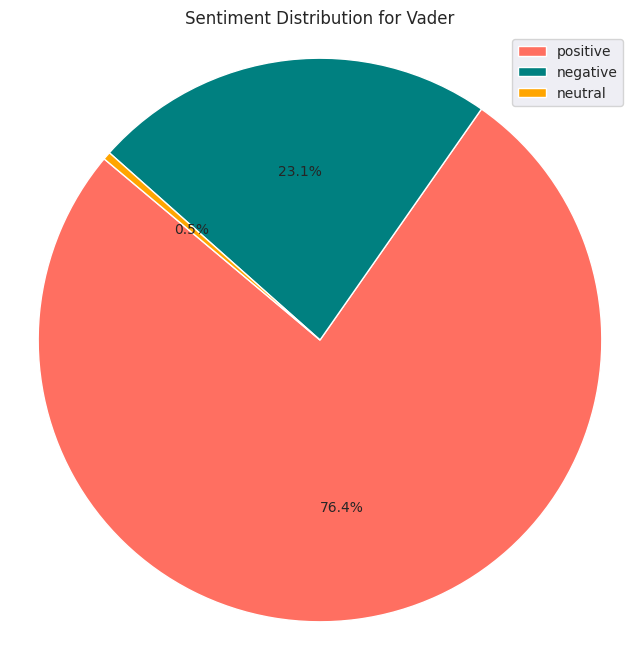

In [48]:
# Plot sentiment distribution for VADER
plot_sentiment_distribution(merged_df, 'vader_sentiment', 'Vader')

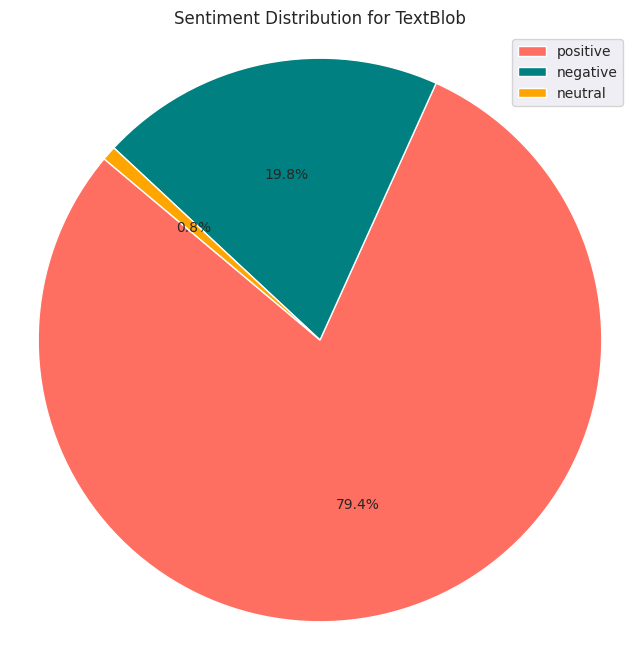

In [49]:
# Plot sentiment distribution for TextBlob
plot_sentiment_distribution(merged_df, 'textblob_sentiment', 'TextBlob')

### 6.4. Explore Top 10 Positive and Negative Sentiment Songs

In [50]:
def plot_wordclouds(df):
    # Filter top 10 positive and negative songs for VADER
    top_vader_positive = df[df['vader_sentiment'] == 'positive'].nlargest(10, 'vader_compound_score')['cleaned_lyrics']
    top_vader_negative = df[df['vader_sentiment'] == 'negative'].nsmallest(10, 'vader_compound_score')['cleaned_lyrics']
    
    # Filter top 10 positive and negative songs for TextBlob
    top_textblob_positive = df[df['textblob_sentiment'] == 'positive'].nlargest(10, 'textblob_polarity')['cleaned_lyrics']
    top_textblob_negative = df[df['textblob_sentiment'] == 'negative'].nsmallest(10, 'textblob_polarity')['cleaned_lyrics']
    
    # Generate word clouds
    vader_positive_text = ' '.join(top_vader_positive)
    vader_negative_text = ' '.join(top_vader_negative)
    textblob_positive_text = ' '.join(top_textblob_positive)
    textblob_negative_text = ' '.join(top_textblob_negative)
    
    vader_positive_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(vader_positive_text)
    vader_negative_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(vader_negative_text)
    textblob_positive_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(textblob_positive_text)
    textblob_negative_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(textblob_negative_text)
    
    # Plot the word clouds
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    axes[0, 0].imshow(vader_positive_wordcloud, interpolation='bilinear')
    axes[0, 0].set_title('Top 10 Positive Songs (VADER)', fontsize=20)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(textblob_positive_wordcloud, interpolation='bilinear')
    axes[0, 1].set_title('Top 10 Positive Songs (TextBlob)', fontsize=20)
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(vader_negative_wordcloud, interpolation='bilinear')
    axes[1, 0].set_title('Top 10 Negative Songs (VADER)', fontsize=20)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(textblob_negative_wordcloud, interpolation='bilinear')
    axes[1, 1].set_title('Top 10 Negative Songs (TextBlob)', fontsize=20)
    axes[1, 1].axis('off')
    
    plt.subplots_adjust(wspace=-1, hspace=-1)
    fig.tight_layout()
    
    # Save the figure
    fig.savefig('wordclouds.png', bbox_inches='tight')
    
    plt.show()

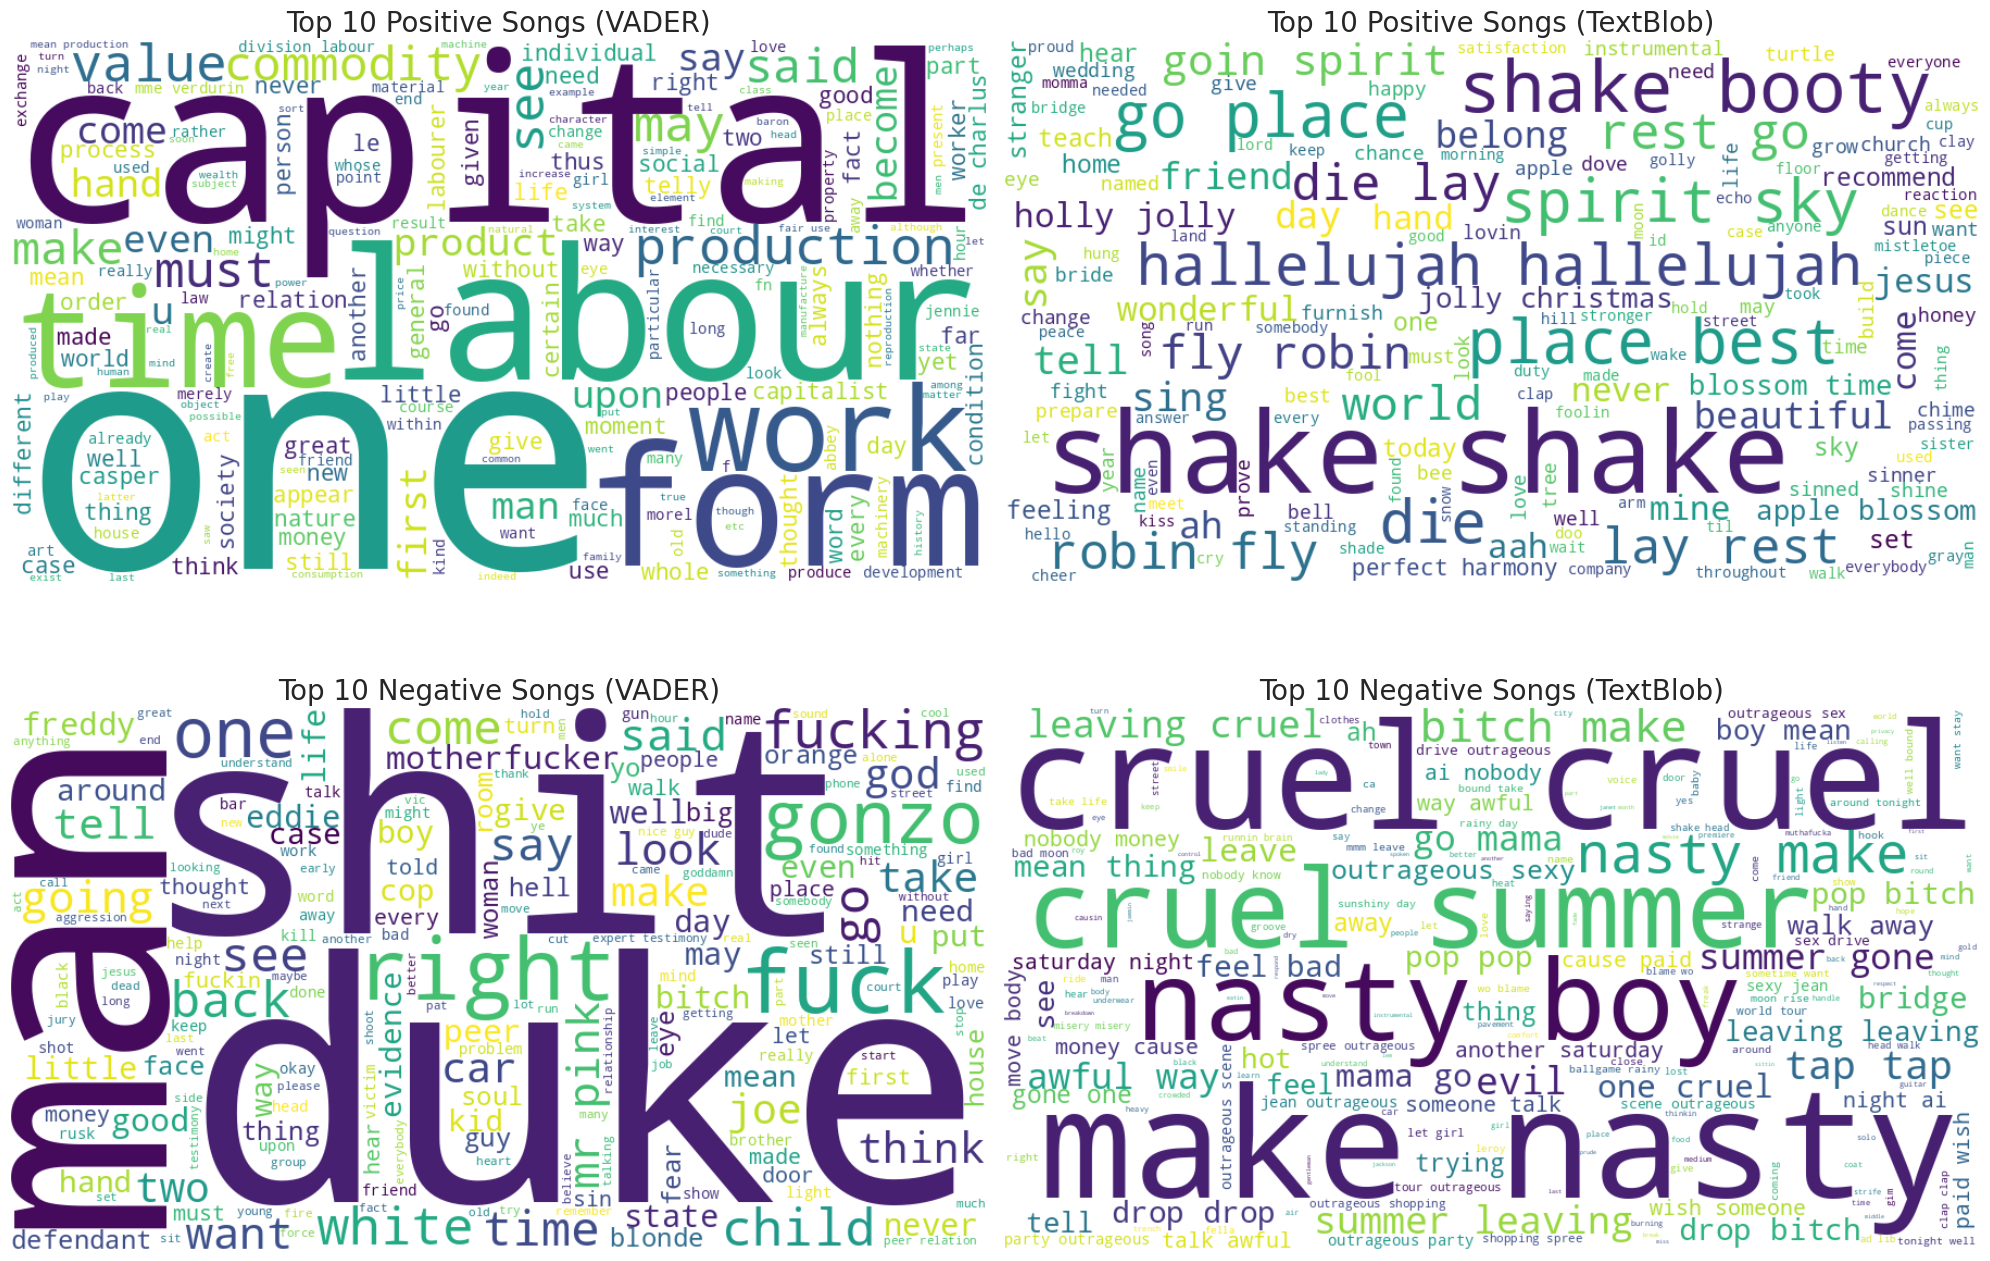

In [51]:
# Plot the word clouds
plot_wordclouds(merged_df)

Key Observations:
1. Vader

>- Positive Songs: The word cloud for positive songs according to VADER includes terms like “love,” “time,” “best,” and “friend.” These suggest themes of affection and companionship.
>- Negative Songs: In the negative songs word cloud, profanity and harsh language are much more prevalent like "fucking", "bitch", "nasty", etc.

2. TextBlob

>- Positive Songs: TextBlob’s analysis reveals terms like “shake,” possibly related to dancing, along with “beautiful” and “holy.” Positive songs tend to use more uplifting, spiritual, and action-oriented language.
>- Negative Songs: TextBlob identifies words like “cruel,” “nasty,” and “bitch,” along with context-specific terms like “summer.”

In [52]:
textblob_neutral = ' '.join(merged_df[merged_df['textblob_sentiment'] == 'neutral']['cleaned_lyrics'])
vader_neutral = ' '.join(merged_df[merged_df['vader_sentiment'] == 'neutral']['cleaned_lyrics'])

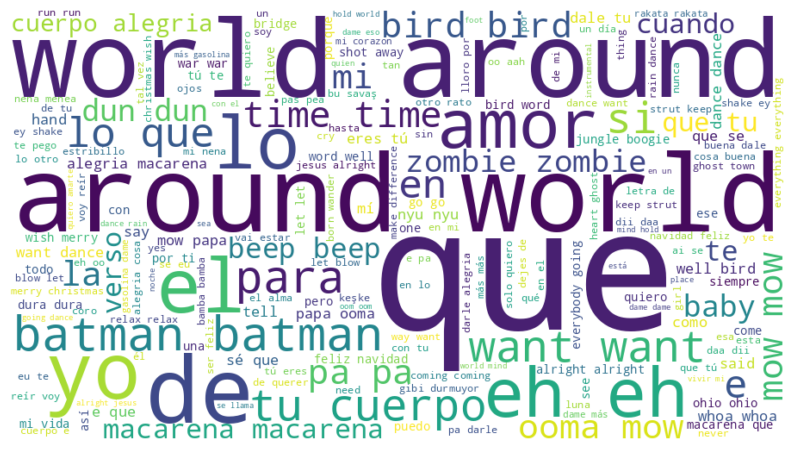

In [53]:
wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(textblob_neutral)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

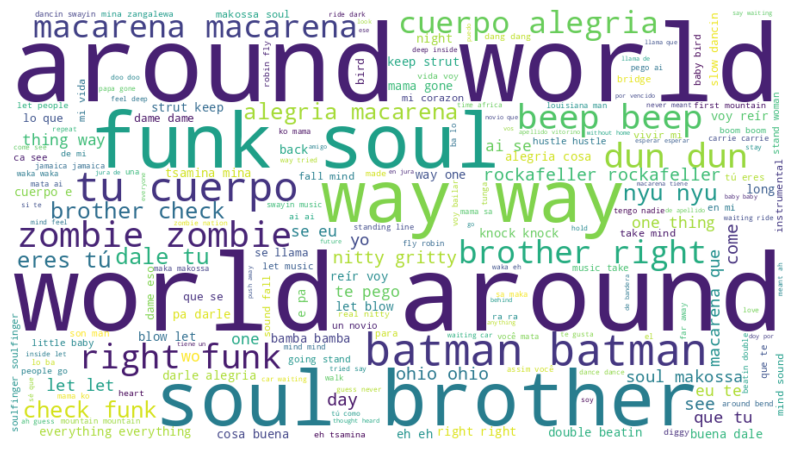

In [54]:
wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(vader_neutral)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In my opinion, VADER does an excellent job in identifying the sentiment in music lyrics. For instance, the word cloud for positive sentiment using TextBlob includes words such as "die," "booty," "sinner," and "sinned," which don't seem particularly positive to me.

When it comes to negative sentiment, it's somewhat subjective, but I prefer VADER. It effectively captures intensely negative words like "motherfucker," "fuck," "shot," and others.

As for neutral sentiment, both VADER and TextBlob perform similarly, providing comparable results.

Therefore, moving forward, all our sentiment analysis will be based on VADER primarily. Uhhh... maybe borrow from textblob too.

## 7. Business Questions

Obviously, we can't cover every possible business question that could arise from this data, as it depends on what we are specifically looking for. In our case, I have posed a few questions that we might typically ask in a sentiment analysis project.

### 7.1. Which songs have the most extreme sentiment scores (both positive and negative)? What might account for these?

In [55]:
merged_df.sort_values(by=['vader_compound_score', 'textblob_polarity'], ascending=True).head(1)

,song_id,song_name,billboard,artists,popularity,explicit,song_type,lyrics,duration_ms,key,...,loudness,speechiness,valence,tempo,cleaned_artists,cleaned_lyrics,vader_compound_score,vader_sentiment,textblob_polarity,textblob_sentiment
14927,0SGu9ADkwx5uRjwGv1K987,"Woman Like That , Yeah","('Woman Like That, Yeah', 'Joe Tex')",{'5TbXjzD8tYgMD5JU2g2F8q': 'Joe Tex'},0,False,Solo,['Ladies and gentlemen !\n\nEddie Murphy!\n\n\...,192907,2,...,-6.537,0.0322,0.742,119.944,Joe Tex,gentleman eddie murphy thank thank much kind f...,-1.0,negative,-0.097609,negative


<span style="color: red;">Warning!!!</span>
    
According to VADER and TextBlob, "Woman Like That, Yeah" by Joe Tex is identified as the most negative song. Here is a snippet of what the lyrics look like:

"gentleman eddie murphy thank thank much kind far kind even get started big round applause bus boy rule rule show standup rule shit faggot allowed look as stage keep moving faggot section keep moving see quick switch get long stare shit imagination flowing looking as start get hot afraid gay people petrified nightmare gay people nightmare go hollywood find faggot really walking people going boy boy look mighty cute jean come fuck as bend boy slow miss round come fast make get get mad clench buttcheeks rip dick would funny faggot ralph kramden ed norton ralph kramden leaning window norton come show whaddaya say pal mine norton watching watching watch ralph norton friend would like fuck as fuck norton fuck bend start go groan hamana hamana hamana way go kid homosexual lot homosexual fuck everybody give fuck like mean anything hang gay person guy feel alienated..."

However, when I look up the lyrics online, there seems to be a mismatch. The lyrics appear to belong to a different song or something else entirely. Therefore, I cannot definitively conclude which song is the most negative or positive based on these lyrics.

### 7.2. What is the overall sentiment of songs by a particular artist?

Here, I am interested in knowing the sentiment in Drake's solo songs. 

In [56]:
def plot_sentiment_distribution(df, artist='Drake'):
    # Filter the DataFrame for the specified artist's solo songs
    filtered_songs = df[(df['song_type'] == 'Solo') & (df['cleaned_artists'] == artist)]
    
    # Count the occurrences of each sentiment for VADER and TextBlob
    vader_sentiment_counts = filtered_songs['vader_sentiment'].value_counts()
    textblob_sentiment_counts = filtered_songs['textblob_sentiment'].value_counts()

    # Plot the bar charts side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # VADER sentiment bar chart
    vader_sentiment_counts.plot(kind='bar', color=['#FF6F61', '#008080', '#FFA500'], ax=axes[0])
    axes[0].set_title(f"VADER Sentiment Distribution in {artist}'s Solo Songs")
    axes[0].set_xlabel("Sentiment")
    axes[0].set_ylabel("Number of Songs")
    axes[0].set_xticks(range(len(vader_sentiment_counts.index)))
    axes[0].set_xticklabels(vader_sentiment_counts.index, rotation=0)

    # Add the count at the top of each bar for VADER
    for index, value in enumerate(vader_sentiment_counts):
        axes[0].text(index, value, str(value), ha='center', va='bottom')

    # TextBlob sentiment bar chart
    textblob_sentiment_counts.plot(kind='bar', color=['#FF6F61', '#008080', '#FFA500'], ax=axes[1])
    axes[1].set_title(f"TextBlob Sentiment Distribution in {artist}'s Solo Songs")
    axes[1].set_xlabel("Sentiment")
    axes[1].set_ylabel("Number of Songs")
    axes[1].set_xticks(range(len(textblob_sentiment_counts.index)))
    axes[1].set_xticklabels(textblob_sentiment_counts.index, rotation=0)

    # Add the count at the top of each bar for TextBlob
    for index, value in enumerate(textblob_sentiment_counts):
        axes[1].text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

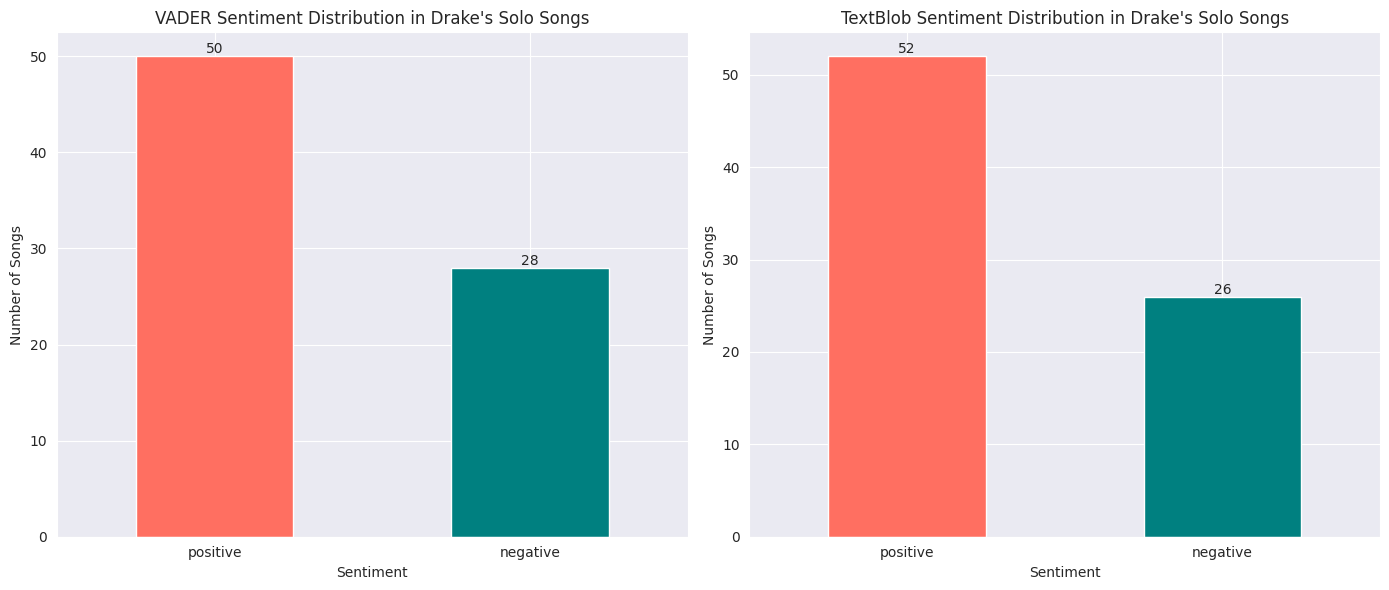

In [57]:
plot_sentiment_distribution(merged_df)

So I have tried to make this generic so you can check for other artists too. For example, we check for Travis Scott 😎

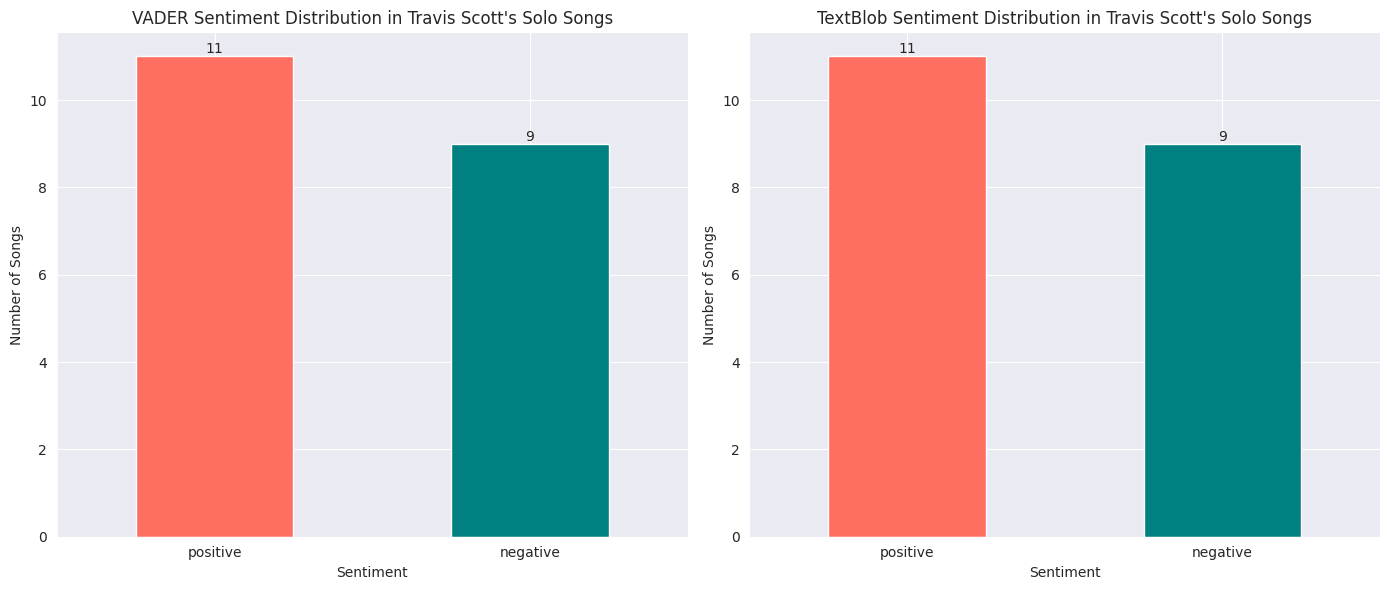

In [58]:
plot_sentiment_distribution(merged_df, 'Travis Scott')

Majority of Drake’s songs are classified as positive according to the VADER and TextBlob algorithm.

### 7.3.  Is there a correlation between the sentiment of song lyrics and their popularity? Do more positive songs tend to be more popular? 

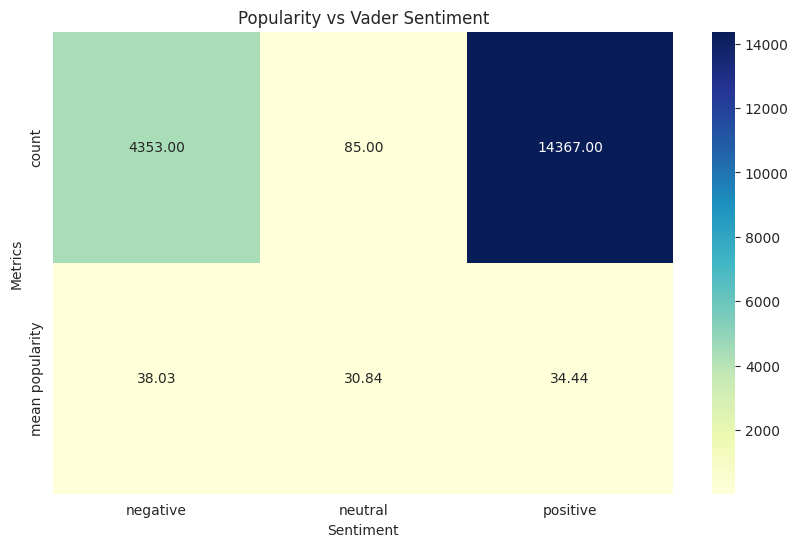

In [59]:
# Define the sentiment categories and their counts and means
sentiment_counts = merged_df['vader_sentiment'].value_counts()
sentiment_means = merged_df.groupby('vader_sentiment')['popularity'].mean()

# Plotting the heatmap
plt.figure(figsize=(10, 6))


# Plot the heatmap
sns.heatmap(pd.DataFrame({'count': sentiment_counts, 'mean popularity': sentiment_means}).T,
            annot=True, cmap='YlGnBu', fmt='.2f')

plt.title('Popularity vs Vader Sentiment')
plt.ylabel('Metrics')
plt.xlabel('Sentiment')
plt.show()

Key observations:

- Negative Sentiment: The ‘negative’ sentiment category has a count of 4353. The mean popularity associated with negative sentiment is 38.03.
- Neutral Sentiment: The ‘neutral’ sentiment category has a count of 85. The mean popularity for neutral sentiment is 30.84.
- Positive Sentiment: The ‘positive’ sentiment category has a count of 14367. The mean popularity for positive sentiment is 34.44.

Hmmm... It’s interesting to note that despite there being approximately three times as many positive songs, the negative songs still exhibit higher popularity. This might be attributed to various factors. Overall, we can say that negative songs are more likely to be popular. Alright, it is important to note that popularity isn’t solely determined by sentiment; other elements like melody, lyrics, and artist reputation also play a significant role. 🎵📈😉😎

### 7.4. Is there any relationship between acousticness of a song and its sentiment?

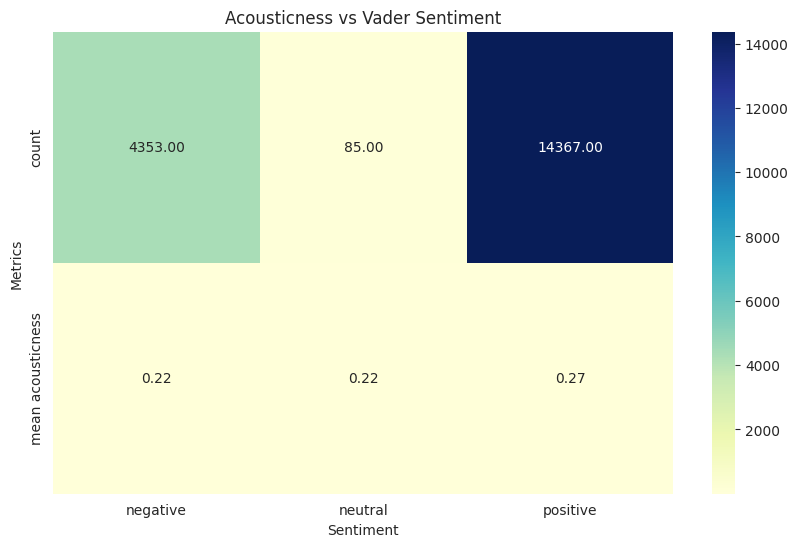

In [60]:
# Define the sentiment categories and their counts and means of acousticness
sentiment_counts = merged_df['vader_sentiment'].value_counts()
sentiment_means = merged_df.groupby('vader_sentiment')['acousticness'].mean()

# Plotting the heatmap
plt.figure(figsize=(10, 6))

# Plot the heatmap with count and mean acousticness values
sns.heatmap(pd.DataFrame({'count': sentiment_counts, 'mean acousticness': sentiment_means}).T,
            annot=True, cmap='YlGnBu', fmt='.2f')

plt.title('Acousticness vs Vader Sentiment')
plt.ylabel('Metrics')
plt.xlabel('Sentiment')
plt.show()

Acousticness refers to the degree to which a song sounds acoustic or non-electronic. The acousticness in the data goes from 0.0 to 1.0 where 1.0 represents a high confidence that the track is acoustic. Interestingly, both negative and neutral songs have similar mean acousticness (around 0.22). Positive songs, on the other hand, exhibit slightly higher mean acousticness (around 0.27). 

## 8. Modeling Popularity and Sentiment

Alright, we've made significant progress. Just to say this first hand. I'm not particularly enthusiastic about this section. Firstly, we're only utilizing a single feature, and secondly, the dataset's severe imbalance kind of makes everything worst. Therefore, I don't anticipate meaningful outcomes from this approach.

In [61]:
# Encode sentiment labels
merged_df['sentiment_label'] = merged_df['vader_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Define features (X) and target (y)
X = merged_df[['popularity']]
y = merged_df['sentiment_label']

# Initialize stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []

In [62]:
# Iterate through folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # Store metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(confusion_mat)

In [63]:
# Compute average metrics across folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

# Print average metrics
print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-score: {avg_f1:.2f}")

Average Accuracy: 0.76
Average Precision: 0.76
Average Recall: 1.00
Average F1-score: 0.87


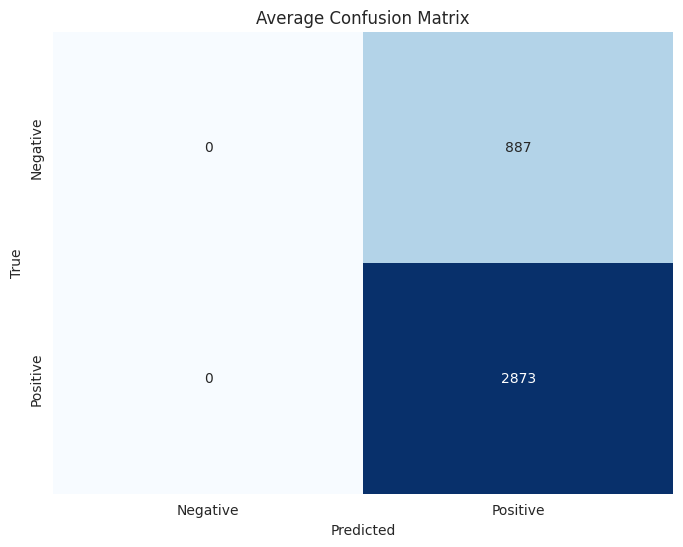

In [64]:
# Plot average confusion matrix
avg_conf_matrix = sum(conf_matrices) // len(conf_matrices)
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

Hmmm... Just as I said earlier. But it doesnt hurt to try, does it?

## 9. Save Cleaned Data

In [65]:
merged_df.drop(columns=['lyrics']).to_csv('final_df.csv', index=None)

## 10. Future Improvements

Of course this notebook is not the end. Potential improvements or additions include

- Conduct more in-depth exploratory data analysis.
- Pose and address additional business-value questions.
- Explore the use of multiple features to better correlate or predict a song's sentiment.

<span style="color: red;">Disclaimer! Disclaimer! Disclaimer!</span>
 
All the analyses conducted in this notebook are based solely on the provided dataset. The inferences drawn should not be interpreted as reflections of real-world situations. Additionally, I am not responsible for any incorrect conclusions that may arise due to inaccuracies or issues within the dataset. Please use this analysis with caution and consider verifying the results with additional data sources before making any decisions based on the findings.

Thank you!!! 😊